In [1]:
import pandas as pd
import numpy as np
np.set_printoptions(suppress=True) # Suppress scientific notation where possible

from ast import literal_eval

import re
import string

In [2]:
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk

In [4]:
import spacy
from rake_nltk import Rake

In [5]:
import gensim
from gensim.parsing.preprocessing import STOPWORDS

In [6]:
from nltk.stem import PorterStemmer, SnowballStemmer, LancasterStemmer

In [7]:
from sklearn.decomposition import TruncatedSVD

from scipy.sparse import csr_matrix

from sklearn.preprocessing import StandardScaler

In [8]:
import seaborn as sns

from matplotlib import pyplot as plt
%config InlineBackend.figure_formats = ['retina']  # or svg
%matplotlib inline

In [9]:
# Make some room to see stuff (i.e. drop display limits on Pandas rows & cols - be careful w/ big df's!)

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', None)

## 1) Read in the data

In [10]:
movies = pd.read_csv('final_dataset.csv', lineterminator='\n', index_col=0)
print(movies.shape)
movies.head()

(47723, 8)


,movieId,tmdbId,imdbId,title,genres,overview,director,actors
0,1,862,114709,Toy Story,"['Adventure', 'Animation', 'Children', 'Comedy...","Led by Woody, Andy's toys live happily in his ...",john_lasseter,"['tom_hanks', 'tim_allen', 'don_rickles', 'jim..."
1,2,8844,113497,Jumanji,"['Adventure', 'Children', 'Fantasy']",When siblings Judy and Peter discover an encha...,joe_johnston,"['robin_williams', 'kirsten_dunst', 'bradley_p..."
2,3,15602,113228,Grumpier Old Men,"['Comedy', 'Romance']",A family wedding reignites the ancient feud be...,howard_deutch,"['walter_matthau', 'jack_lemmon', 'ann-margret..."
3,4,31357,114885,Waiting to Exhale,"['Comedy', 'Drama', 'Romance']","Cheated on, mistreated and stepped on, the wom...",forest_whitaker,"['whitney_houston', 'angela_bassett', 'loretta..."
4,5,11862,113041,Father of the Bride Part II,['Comedy'],Just when George Banks has recovered from his ...,charles_shyer,"['steve_martin', 'diane_keaton', 'martin_short..."


#### Lists in columns got turned into text strings during save to csv; need to undo that

In [11]:
movies['genres'] = movies['genres'].map(literal_eval)
movies['actors'] = movies['actors'].map(literal_eval)
movies.head()

,movieId,tmdbId,imdbId,title,genres,overview,director,actors
0,1,862,114709,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]","Led by Woody, Andy's toys live happily in his ...",john_lasseter,"[tom_hanks, tim_allen, don_rickles, jim_varney]"
1,2,8844,113497,Jumanji,"[Adventure, Children, Fantasy]",When siblings Judy and Peter discover an encha...,joe_johnston,"[robin_williams, kirsten_dunst, bradley_pierce..."
2,3,15602,113228,Grumpier Old Men,"[Comedy, Romance]",A family wedding reignites the ancient feud be...,howard_deutch,"[walter_matthau, jack_lemmon, ann-margret, sop..."
3,4,31357,114885,Waiting to Exhale,"[Comedy, Drama, Romance]","Cheated on, mistreated and stepped on, the wom...",forest_whitaker,"[whitney_houston, angela_bassett, loretta_devi..."
4,5,11862,113041,Father of the Bride Part II,[Comedy],Just when George Banks has recovered from his ...,charles_shyer,"[steve_martin, diane_keaton, martin_short, kim..."


## 2) Tokenize the 'overview' column

#### This time, we'll try the rake_nltk keyword extractor on the corpus

#### Start by removing digits, capital letters and punctuation

In [12]:
alpha = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_and_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

movies['plot_tokens'] = movies['overview'].map(alpha).map(punc_and_lower)

In [13]:
raker = Rake(stopwords=list(STOPWORDS), max_length=2)

movies['plot_tokens'] = ''
for n, row in movies.iterrows():
    raker.extract_keywords_from_text(row['overview'])
    movies.at[n,'plot_tokens'] = list(set(raker.get_ranked_phrases()))

In [14]:
movies['plot_tokens']

0        [scene, differences, woody, aside, andy, place...
1        [terrifying creatures, hope, game, alan, freed...
2        [interested, max, cooking, s, alarming, hot ti...
3        [mistreated, bernie, cheated, confidants vanna...
4        [george banks, arrival, recovered, s wife, s, ...
                               ...                        
47718    [day, worries, starting, 18, sets, moved, stay...
47719    [star, wants, mixed emotions, quit, blondie de...
47720    [number, later exposing, big city, hired, tryi...
47721    [escape, discover, expedition, 1929, uncharted...
47722    [senad, border, paraguay, argentina, colonel f...
Name: plot_tokens, Length: 47723, dtype: object

In [15]:
movies['genres'] = movies['genres'].map(lambda x: [el.lower() for el in x])
movies.head()

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens
0,1,862,114709,Toy Story,"[adventure, animation, children, comedy, fantasy]","Led by Woody, Andy's toys live happily in his ...",john_lasseter,"[tom_hanks, tim_allen, don_rickles, jim_varney]","[scene, differences, woody, aside, andy, place..."
1,2,8844,113497,Jumanji,"[adventure, children, fantasy]",When siblings Judy and Peter discover an encha...,joe_johnston,"[robin_williams, kirsten_dunst, bradley_pierce...","[terrifying creatures, hope, game, alan, freed..."
2,3,15602,113228,Grumpier Old Men,"[comedy, romance]",A family wedding reignites the ancient feud be...,howard_deutch,"[walter_matthau, jack_lemmon, ann-margret, sop...","[interested, max, cooking, s, alarming, hot ti..."
3,4,31357,114885,Waiting to Exhale,"[comedy, drama, romance]","Cheated on, mistreated and stepped on, the wom...",forest_whitaker,"[whitney_houston, angela_bassett, loretta_devi...","[mistreated, bernie, cheated, confidants vanna..."
4,5,11862,113041,Father of the Bride Part II,[comedy],Just when George Banks has recovered from his ...,charles_shyer,"[steve_martin, diane_keaton, martin_short, kim...","[george banks, arrival, recovered, s wife, s, ..."


In [16]:
movies['director'] = movies['director'].map(lambda x: [x])
movies.head()

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens
0,1,862,114709,Toy Story,"[adventure, animation, children, comedy, fantasy]","Led by Woody, Andy's toys live happily in his ...",[john_lasseter],"[tom_hanks, tim_allen, don_rickles, jim_varney]","[scene, differences, woody, aside, andy, place..."
1,2,8844,113497,Jumanji,"[adventure, children, fantasy]",When siblings Judy and Peter discover an encha...,[joe_johnston],"[robin_williams, kirsten_dunst, bradley_pierce...","[terrifying creatures, hope, game, alan, freed..."
2,3,15602,113228,Grumpier Old Men,"[comedy, romance]",A family wedding reignites the ancient feud be...,[howard_deutch],"[walter_matthau, jack_lemmon, ann-margret, sop...","[interested, max, cooking, s, alarming, hot ti..."
3,4,31357,114885,Waiting to Exhale,"[comedy, drama, romance]","Cheated on, mistreated and stepped on, the wom...",[forest_whitaker],"[whitney_houston, angela_bassett, loretta_devi...","[mistreated, bernie, cheated, confidants vanna..."
4,5,11862,113041,Father of the Bride Part II,[comedy],Just when George Banks has recovered from his ...,[charles_shyer],"[steve_martin, diane_keaton, martin_short, kim...","[george banks, arrival, recovered, s wife, s, ..."


#### Combine all tokens into one 'corpus' column

In [17]:
cols = ['genres', 'director', 'actors', 'plot_tokens']

movies['corpus'] = ''

for n, row in movies.iterrows():
    val = ''
    for col in cols:
        val += ' '.join(row[col])
        val += ' '
    movies.at[n,'corpus'] = val

In [18]:
movies.head()

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens,corpus
0,1,862,114709,Toy Story,"[adventure, animation, children, comedy, fantasy]","Led by Woody, Andy's toys live happily in his ...",[john_lasseter],"[tom_hanks, tim_allen, don_rickles, jim_varney]","[scene, differences, woody, aside, andy, place...",adventure animation children comedy fantasy jo...
1,2,8844,113497,Jumanji,"[adventure, children, fantasy]",When siblings Judy and Peter discover an encha...,[joe_johnston],"[robin_williams, kirsten_dunst, bradley_pierce...","[terrifying creatures, hope, game, alan, freed...",adventure children fantasy joe_johnston robin_...
2,3,15602,113228,Grumpier Old Men,"[comedy, romance]",A family wedding reignites the ancient feud be...,[howard_deutch],"[walter_matthau, jack_lemmon, ann-margret, sop...","[interested, max, cooking, s, alarming, hot ti...",comedy romance howard_deutch walter_matthau ja...
3,4,31357,114885,Waiting to Exhale,"[comedy, drama, romance]","Cheated on, mistreated and stepped on, the wom...",[forest_whitaker],"[whitney_houston, angela_bassett, loretta_devi...","[mistreated, bernie, cheated, confidants vanna...",comedy drama romance forest_whitaker whitney_h...
4,5,11862,113041,Father of the Bride Part II,[comedy],Just when George Banks has recovered from his ...,[charles_shyer],"[steve_martin, diane_keaton, martin_short, kim...","[george banks, arrival, recovered, s wife, s, ...",comedy charles_shyer steve_martin diane_keaton...


In [19]:
movies['corpus'][0]

'adventure animation children comedy fantasy john_lasseter tom_hanks tim_allen don_rickles jim_varney scene differences woody aside andy place owner led s heart woody plots buzz room losing afraid '

#### Build a Stemmer and Stopword function for use w/ the Vectorizer; Let's use a "better" English stopword list than the NLTK default

In [20]:
# Using the "better" Gensim English STOPWORDS list instead of the NLTK default list

stemmer = SnowballStemmer('english')

def prep(word, stemmer=stemmer):
    
    stopwords = list(STOPWORDS)
        
    if word.lower() in stopwords:
        return None
    
    elif stemmer is None:
        return word.lower()
    
    else:
        return stemmer.stem(word)

In [25]:
# CountVectorizer(stop_words=None, max_df=0.7, )

cv1 = CountVectorizer(stop_words=list(STOPWORDS), preprocessor=prep, ngram_range=(1, 2), min_df=0.02)

X_cv1 = cv1.fit_transform(movies['corpus'])

doc_term = pd.DataFrame(X_cv1.toarray(), columns=cv1.get_feature_names())
doc_term.shape

(47723, 111)

In [26]:
doc_term.head()

,action,action adventure,action crime,action drama,adventure,animation,based,begins,best,boy,brother,children,children comedy,city,come,comedy,comedy crime,comedy drama,comedy romance,comes,crime,crime drama,daughter,day,dead,death,decides,discovers,documentary,drama,drama romance,drama thriller,end,falls,family,fantasy,father,fi,fight,film,finds,forced,friend,friends,gets,girl,goes,group,help,home,horror,horror thriller,house,husband,job,life,like,live,lives,living,long,love,man,meets,men,money,mother,murder,musical,mysterious,mystery,mystery thriller,new,night,old,order,past,people,police,relationship,romance,save,school,sci,sci fi,secret,set,small,son,soon,story,takes,thriller,time,town,tries,true,trying,turn,wants,war,way,western,wife,woman,women,work,world,year,years,young
0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


#### Now apply dimensionality reduction to the dataset

In [27]:
svd = TruncatedSVD(n_components=40, n_iter=50, random_state=42)
svd.fit(X_cv1.T)

TruncatedSVD(n_components=40, n_iter=50, random_state=42)

In [28]:
print(svd.explained_variance_ratio_)

print(svd.explained_variance_ratio_.sum())

[0.08973626 0.05654595 0.04587544 0.03449606 0.02964546 0.02801789
 0.02473581 0.02292926 0.01850093 0.01820432 0.01715769 0.01625102
 0.01585686 0.0154698  0.01513891 0.01325553 0.01281387 0.01250013
 0.01221689 0.01212485 0.01189215 0.01167099 0.01105652 0.01074953
 0.01031442 0.00987614 0.00968365 0.00936085 0.00910211 0.00881977
 0.00887245 0.00855214 0.00843716 0.00808302 0.00804176 0.00785667
 0.0077527  0.00763891 0.0074493  0.00732389]
0.6940070541340733


In [29]:
svd.components_.T.shape

(47723, 40)

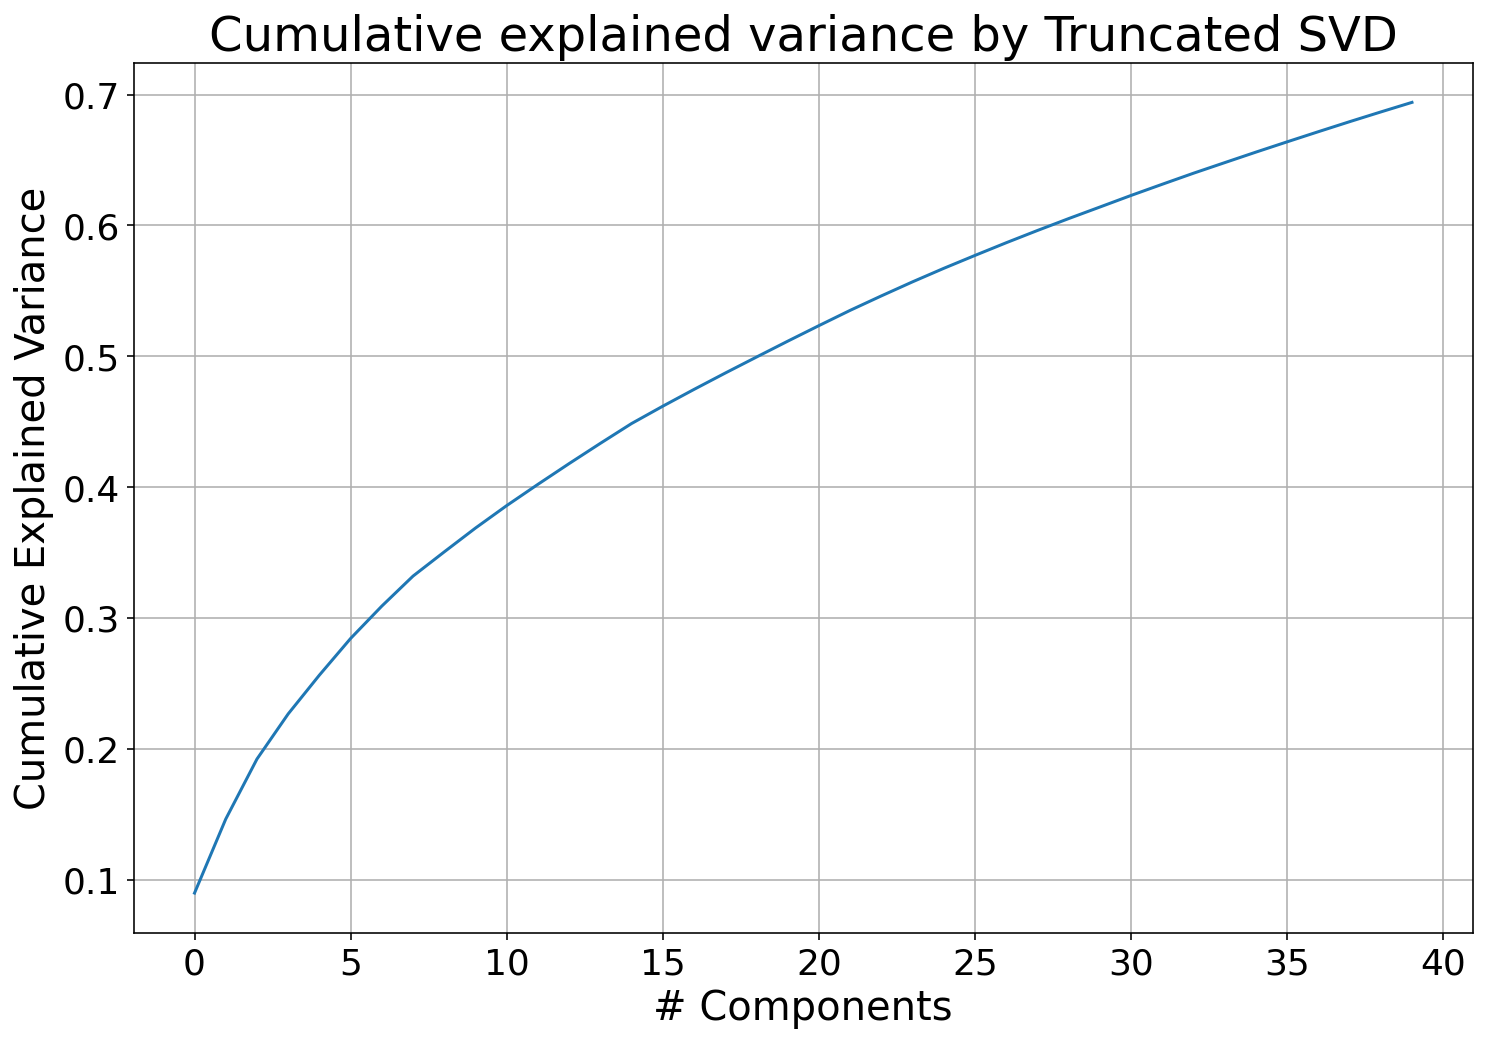

In [30]:
plt.figure(figsize=(12, 8))
plt.plot(np.cumsum(svd.explained_variance_ratio_))
plt.xlabel('# Components', size=20)
plt.ylabel('Cumulative Explained Variance', size=20)
plt.xticks(size=18)
plt.yticks(size=18)
plt.title('Cumulative explained variance by Truncated SVD', size=24)
plt.grid();

In [31]:
mat = pd.DataFrame(data=svd.components_.T, index=movies.index)
mat

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,0.002866,0.007882,0.004247,-0.000408,-0.005679,0.003582,0.004133,-0.006547,0.011676,-0.009396,-0.010764,-0.006722,-0.006663,0.002753,0.001446,-0.004993,-0.001608,0.003514,-0.003853,-0.003150,-0.005236,0.001575,-0.002589,-0.000490,0.000565,0.002293,-0.000595,0.001591,-0.000839,-0.004219,0.002081,-0.000661,0.003100,0.001348,-0.001171,0.008210,-0.001726,-0.004391,0.001895,0.000557
1,0.001434,0.000979,0.003225,-0.003699,-0.003726,0.002066,0.006239,-0.005619,0.010845,-0.005091,-0.010039,-0.005790,-0.005469,0.001138,-0.000123,-0.002090,-0.005902,-0.000143,0.000568,-0.008803,0.007740,0.003429,-0.001766,0.005289,0.004789,0.001987,-0.000528,0.000506,0.001961,-0.003181,0.002136,0.000156,0.002098,0.002127,-0.001827,0.005865,-0.000003,-0.004133,0.002619,0.000551
2,0.003372,0.008909,-0.000113,-0.000046,0.007102,0.001370,-0.000210,0.000984,-0.000039,0.001177,-0.002338,0.000360,0.001529,0.002470,-0.003134,0.002053,0.003241,0.000368,-0.000594,0.001535,0.000743,-0.000910,0.014516,0.001150,-0.000965,0.006717,0.002217,0.000962,-0.007362,-0.010312,0.000220,-0.005064,-0.001043,-0.002674,0.000235,-0.002831,0.000058,-0.000114,0.001881,0.000529
3,0.008826,0.006508,-0.005003,-0.001671,0.005420,0.001776,-0.005259,-0.001230,-0.002094,0.001210,0.004028,-0.003934,-0.005468,-0.000745,-0.010703,-0.003853,-0.006841,0.002425,-0.003854,-0.001727,0.001325,0.000972,0.001238,-0.001426,-0.007393,-0.000238,0.004131,-0.001958,0.002362,0.018683,-0.005369,0.003612,-0.008315,-0.004477,0.013316,0.006404,-0.001780,-0.007590,-0.003873,0.001191
4,0.002506,0.006283,0.001290,0.003124,-0.001986,-0.000888,-0.000922,-0.000877,0.000268,-0.000300,0.002699,0.000628,0.001616,0.002789,-0.000906,0.002713,0.000666,-0.001134,-0.002705,0.003155,-0.001867,-0.000296,0.001758,-0.001193,0.014842,-0.004663,-0.006557,-0.008806,0.002002,-0.002210,-0.005371,0.001204,-0.001024,0.000212,0.005051,-0.001767,0.012379,-0.002568,0.012980,-0.001818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47718,0.005511,-0.002332,-0.002186,-0.001594,-0.004643,-0.002506,0.000968,-0.000853,0.003042,-0.000283,0.001016,0.000092,0.003790,-0.000850,-0.001384,0.014040,0.004828,-0.002861,-0.004213,0.002098,0.003369,-0.000752,0.031518,0.000056,-0.009814,0.010282,-0.005234,0.001483,0.000587,-0.008961,-0.006524,-0.000263,0.008714,0.000690,-0.001874,0.000590,0.014966,0.003683,-0.015882,0.002105
47719,0.002615,0.006565,0.001299,0.003242,-0.001882,-0.000631,-0.000815,-0.000091,-0.000290,0.000118,0.002748,-0.000456,0.000588,0.002248,-0.000413,0.003137,0.000885,-0.000874,-0.002387,0.002427,-0.001459,0.000596,0.003913,-0.000708,0.014220,-0.003695,-0.005079,-0.007048,-0.000144,-0.000547,-0.004257,-0.000614,-0.003503,-0.000671,-0.001134,0.000235,-0.000448,-0.000243,-0.001517,-0.003791
47720,0.003613,-0.003043,-0.002768,-0.000656,-0.002786,0.000769,-0.002710,-0.000731,-0.000595,-0.000922,-0.000262,-0.000025,-0.000965,-0.001619,0.000103,0.000700,-0.000791,0.000012,0.000136,0.000004,-0.000718,0.000801,0.000740,-0.000192,0.000282,-0.001181,0.001663,0.000618,-0.003379,-0.001993,-0.000364,-0.000495,-0.000249,-0.000237,0.000292,-0.000328,-0.000339,0.001297,-0.000693,0.000016
47721,0.004923,-0.003542,0.008111,-0.012143,-0.003605,-0.002177,-0.010677,0.001983,0.003468,-0.002979,-0.002862,0.003817,-0.007558,-0.003690,0.000968,-0.005046,-0.003694,-0.004664,-0.000530,0.000957,-0.001670,-0.009009,-0.000324,-0.001908,0.001360,-0.000940,-0.000754,0.000501,-0.003019,-0.003659,-0.001353,-0.001524,-0.001337,-0.001658,-0.000531,-0.005070,0.000186,0.002816,-0.002246,-0.001128


#### Compute Cosine Similarities in this reduced space

In [32]:
del doc_term

cosine_sim = cosine_similarity(mat, mat)
del mat

print(cosine_sim.shape)
print(cosine_sim)
# np.save('cosine_similarities.npy', cosine_sim)

(47723, 47723)
[[ 1.          0.7339897   0.02941361 ... -0.03046622  0.07232643
  -0.04092262]
 [ 0.7339897   1.         -0.07720553 ... -0.06556361  0.03747076
  -0.06708583]
 [ 0.02941361 -0.07720553  1.         ...  0.05633878 -0.01113057
  -0.04629716]
 ...
 [-0.03046622 -0.06556361  0.05633878 ...  1.          0.35738006
   0.24427689]
 [ 0.07232643  0.03747076 -0.01113057 ...  0.35738006  1.
  -0.01295905]
 [-0.04092262 -0.06708583 -0.04629716 ...  0.24427689 -0.01295905
   1.        ]]


In [19]:
# cosine_sim = np.load('cosine_similarities.npy')

In [33]:
def recommend(movie_id, len=20):
    movie_idx = movies[movies['movieId'] == movie_id].index[0]
    rec_indices = cosine_sim[movie_idx,:].argsort()[::-1][0:len+1]
    rec_indices = [rec_idx for rec_idx in rec_indices if rec_idx != movie_idx]
    print('Recommendations based on your interest in {}:'
               .format(movies[movies['movieId'] == movie_id]['title'].values[0]))
    recommendations = movies.iloc[rec_indices, np.r_[3:5, 6:8]]
    recommendations['relevancy'] = cosine_sim[movie_idx, rec_indices]
    return recommendations

In [34]:
recommend(1, 10)

Recommendations based on your interest in Toy Story:


,title,genres,director,actors,relevancy
43963,Olaf's Frozen Adventure,"[adventure, animation, children, comedy, fantasy]",[kevin_deters],"[josh_gad, kristen_bell, idina_menzel, jonatha...",1.000000
20118,Turbo,"[adventure, animation, children, comedy, fantasy]",[david_soren],"[ryan_reynolds, paul_giamatti, michael_peña, s...",1.000000
23127,Hawaiian Vacation,"[adventure, animation, children, comedy, fantasy]",[gary_rydstrom],"[tom_hanks, tim_allen, joan_cusack, don_rickles]",1.000000
2920,Toy Story 2,"[adventure, animation, children, comedy, fantasy]",[john_lasseter],"[tom_hanks, tim_allen, joan_cusack, kelsey_gra...",1.000000
17410,Asterix and the Vikings,"[adventure, animation, children, comedy, fantasy]",[stefan_fjeldmark],"[roger_carel, lorànt_deutsch, sara_forestier, ...",1.000000
3538,The Adventures of Rocky & Bullwinkle,"[adventure, animation, children, comedy, fantasy]",[des_mcanuff],"[rene_russo, jason_alexander, piper_perabo, ra...",0.999336
47450,Penguin Highway,"[adventure, animation, children, comedy, fantasy]",[hiroyasu_ishida],"[kana_kita, yu_aoi, rie_kugimiya, miki_fukui]",0.998869
14959,The Wizard of Oz,"[adventure, children, comedy, fantasy]",[larry_semon],"[dorothy_dwan, mary_carr, charles_murray, oliv...",0.993038
31355,Return to Halloweentown,"[adventure, children, comedy, fantasy]",[david_jackson],"[sara_paxton, judith_hoag, lucas_grabeel, joey...",0.993038
23645,A Connecticut Yankee in King Arthur's Court,"[adventure, children, comedy, fantasy]",[mel_damski],"[keshia_knight_pulliam, michael_gross, jean_ma...",0.992936


In [34]:
movies[movies['title'] == 'Chinatown']

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens,corpus
1161,1252,829,71315,Chinatown,"[crime, film-noir, mystery, thriller]",Private eye Jake Gittes lives off of the murky...,[roman_polanski],"[jack_nicholson, faye_dunaway, john_huston, pe...","[private, eye, jake, gittes, lives, off, of, t...",crime film-noir mystery thriller roman_polansk...


In [35]:
recommend(1252, 10)

Recommendations based on your interest in Chinatown:


,title,genres,director,actors,relevancy
8531,"Farewell, My Lovely","[crime, mystery, thriller]",[dick_richards],"[robert_mitchum, charlotte_rampling, sylvia_mi...",0.988170
16357,Vice,"[crime, film-noir, mystery, thriller]",[raul_inglis],"[michael_madsen, daryl_hannah, mykelti_william...",0.985749
8838,A Pure Formality,"[crime, film-noir, mystery, thriller]",[giuseppe_tornatore],"[gérard_depardieu, roman_polanski, sergio_rubi...",0.977853
1489,L.A. Confidential,"[crime, film-noir, mystery, thriller]",[curtis_hanson],"[kevin_spacey, russell_crowe, guy_pearce, jame...",0.975368
46,Se7en,"[mystery, thriller]",[david_fincher],"[brad_pitt, morgan_freeman, gwyneth_paltrow, k...",0.921630
22141,Backfire,"[crime, film-noir, mystery, romance, thriller]",[vincent_sherman],"[virginia_mayo, gordon_macrae, edmond_o'brien,...",0.914790
25104,Murder Is My Beat,"[film-noir, mystery]",[edgar_g._ulmer],"[paul_langton, barbara_payton, robert_shayne, ...",0.881546
22025,Crack-Up,"[crime, film-noir, mystery]",[irving_reis],"[pat_o’brien, claire_trevor, herbert_marshall,...",0.881546
27558,Too Late for Tears,"[crime, drama, film-noir, mystery, thriller]",[byron_haskin],"[lizabeth_scott, don_defore, dan_duryea, arthu...",0.868554
17016,Follow Me Quietly,"[crime, drama, film-noir, mystery]",[richard_fleischer],"[william_lundigan, dorothy_patrick, jeff_corey...",0.859336


In [36]:
movies[movies['title'] == 'Raging Bull']

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens,corpus
1139,1228,1578,81398,Raging Bull,[drama],"The life of boxer Jake LaMotta, whose violence...",[martin_scorsese],"[robert_de_niro, joe_pesci, cathy_moriarty, fr...","[the, life, of, boxer, jake, lamotta, whose, v...",drama martin_scorsese robert_de_niro joe_pesci...


In [36]:
recommend(1228, 10)

Recommendations based on your interest in Raging Bull:


,title,genres,director,actors,relevancy
46016,Once there was a woman,[drama],[andrey_smirnov],"[nina_ruslanova, vladislav_abashin, roman_mady...",1.000000
42117,Purgatory House,[drama],[cindy_baer],"[celeste_marie_davis, jim_hanks, johnny_pacar,...",1.000000
39630,When the Heavens Fall…,[drama],[risto_jarva],"[eeva-maija_haukinen, erkki_pajala, heikki_häm...",1.000000
35184,Found Memories,[drama],[julia_murat],"[sônia_guedes, lisa_fávero, luiz_serra, ricard...",1.000000
21932,Bright Lights,"[drama, musical]",[michael_curtiz],"[dorothy_mackaill, frank_fay, noah_beery, daph...",0.978017
17470,Shit Year,[drama],[cam_archer],"[ellen_barkin, luke_grimes, bob_einstein, ther...",0.973990
3964,The Greatest Story Ever Told,[drama],[george_stevens],"[max_von_sydow, michael_anderson_jr., carroll_...",0.967864
10534,Stromboli,[drama],[roberto_rossellini],"[ingrid_bergman, mario_vitale, renzo_cesana, m...",0.955055
9036,Gojoe: Spirit War Chronicle,[drama],[gakuryû_ishii],"[tadanobu_asano, masatoshi_nagase, daisuke_ryû...",0.955055
7053,"Brother Sun, Sister Moon",[drama],[franco_zeffirelli],"[graham_faulkner, judi_bowker, leigh_lawson, k...",0.955020


In [38]:
movies[movies['title'] == 'Happy Gilmore']

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens,corpus
102,104,9614,116483,Happy Gilmore,[comedy],Failed hockey player-turned-golf whiz Happy Gi...,[dennis_dugan],"[adam_sandler, christopher_mcdonald, julie_bow...","[failed, hockey, player, turned, golf, whiz, h...",comedy dennis_dugan adam_sandler christopher_m...


In [37]:
recommend(104, 10)

Recommendations based on your interest in Happy Gilmore:


,title,genres,director,actors,relevancy
24463,Mexican Spitfire Sees a Ghost,[comedy],[leslie_goodwins],"[lupe_vélez, leon_errol, charles_rogers, elisa...",0.966836
15433,The Finances of the Grand Duke,[comedy],[f.w._murnau],"[harry_liedtke, adolphe_engers, ilka_grüning, ...",0.965465
40214,Going in Style,[comedy],[zach_braff],"[morgan_freeman, michael_caine, alan_arkin, jo...",0.964820
13723,Confidence Reigns,[comedy],[étienne_chatiliez],"[vincent_lindon, cécile_de_france, pierre_vern...",0.964764
44571,Duct Tape Forever,[comedy],[eric_till],"[\tsteve_smith, patrick_mckenna, bob_bainborou...",0.964303
35695,Bowery Bombshell,[comedy],[phil_karlson],"[leo_gorcey, huntz_hall, william_benedict, bob...",0.964303
35689,Smart Alecks,[comedy],[wallace_fox],"[leo_gorcey, bobby_jordan, huntz_hall, gabriel...",0.961809
41761,"Totò, Peppino and... the Sweet Life",[comedy],[sergio_corbucci],"[totò, peppino_de_filippo, francesco_mulè, mar...",0.960437
3866,Born in East L.A.,[comedy],[cheech_marin],"[cheech_marin, paul_rodríguez, daniel_stern, k...",0.960437
27840,In God We Tru$t,[comedy],[marty_feldman],"[marty_feldman, peter_boyle, louise_lasser, ri...",0.959085


In [40]:
movies[movies['title'] == "You've Got Mail"]

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens,corpus
2242,2424,9489,128853,You've Got Mail,"[comedy, romance]","Book superstore magnate, Joe Fox and independe...",[nora_ephron],"[tom_hanks, meg_ryan, greg_kinnear, parker_posey]","[book, superstore, magnate, joe, fox, and, ind...",comedy romance nora_ephron tom_hanks meg_ryan ...


In [38]:
recommend(2424, 10)

Recommendations based on your interest in You've Got Mail:


,title,genres,director,actors,relevancy
5406,Swept Away,"[comedy, romance]",[guy_ritchie],"[madonna, adriano_giannini, bruce_greenwood, j...",0.999016
30765,The 4th Tenor,"[comedy, romance]",[harry_basil],"[rodney_dangerfield, anita_de_simone, annabell...",0.999016
40901,Knots,"[comedy, romance]",[greg_lombardo],"[scott_cohen, john_stamos, annabeth_gish, paul...",0.999016
759,Rendezvous in Paris,"[comedy, romance]",[éric_rohmer],"[clara_bellar, antoine_basler, mathias_mégard,...",0.999016
38796,When You're in Love,"[comedy, romance]",[robert_riskin],"[grace_moore, cary_grant, aline_macmahon, henr...",0.999016
481,Much Ado About Nothing,"[comedy, romance]",[kenneth_branagh],"[denzel_washington, keanu_reeves, michael_keat...",0.999016
347,Four Weddings and a Funeral,"[comedy, romance]",[mike_newell],"[hugh_grant, andie_macdowell, james_fleet, sim...",0.999016
19562,Miguel and William,"[comedy, romance]",[inés_parís],"[elena_anaya, juan_luis_galiardo, will_kemp, g...",0.999016
34290,"Semen, a Love Sample","[comedy, romance]",[daniela_féjerman],"[ernesto_alterio, leticia_dolera, marian_álvar...",0.999016
6072,Down with Love,"[comedy, romance]",[peyton_reed],"[renée_zellweger, ewan_mcgregor, sarah_paulson...",0.999016


In [42]:
movies[movies['title'] == "Reservoir Dogs"]

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens,corpus
1020,1089,500,105236,Reservoir Dogs,"[crime, mystery, thriller]",A botched robbery indicates a police informant...,[quentin_tarantino],"[harvey_keitel, tim_roth, michael_madsen, chri...","[a, botched, robbery, indicates, a, police, in...",crime mystery thriller quentin_tarantino harve...


In [39]:
recommend(1089, 10)

Recommendations based on your interest in Reservoir Dogs:


,title,genres,director,actors,relevancy
33533,The Assassin,"[crime, mystery, thriller]",[elio_petri],"[marcello_mastroianni, micheline_presle, crist...",1.000000
28209,Man from Reno,"[crime, mystery, thriller]",[dave_boyle],"[ayako_fujitani, pepe_serna, kazuki_kitamura, ...",0.998595
41435,One Way,"[crime, mystery, thriller]",[reto_salimbeni],"[til_schweiger, lauren_lee_smith, sebastien_ro...",0.998181
36225,The Nice Guys,"[crime, mystery, thriller]",[shane_black],"[russell_crowe, ryan_gosling, angourie_rice, m...",0.998181
28240,Lost,"[crime, mystery, thriller]",[guy_green],"[david_farrar, david_knight, julia_arnall, ant...",0.998181
5361,Red Dragon,"[crime, mystery, thriller]",[brett_ratner],"[anthony_hopkins, edward_norton, ralph_fiennes...",0.998181
28835,Ten Little Indians,"[crime, mystery, thriller]",[alan_birkinshaw],"[donald_pleasence, brenda_vaccaro, frank_stall...",0.998181
45425,Murder on the Home Front,"[crime, mystery, thriller]",[geoffrey_sax],"[tamzin_merchant, patrick_kennedy, emerald_fen...",0.998181
18047,Columbus Circle,"[crime, mystery, thriller]",[george_gallo],"[selma_blair, jason_lee, amy_smart, giovanni_r...",0.998055
18845,Fog Over Frisco,"[crime, mystery, thriller]",[william_dieterle],"[bette_davis, donald_woods, margaret_lindsay, ...",0.997766


In [44]:
movies[movies['title'] == "Star Wars"]

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens,corpus
252,260,11,76759,Star Wars,"[action, adventure, sci-fi]",Princess Leia is captured and held hostage by ...,[george_lucas],"[mark_hamill, harrison_ford, carrie_fisher, pe...","[princess, leia, is, captured, and, held, host...",action adventure sci-fi george_lucas mark_hami...


In [40]:
recommend(260, 10)

Recommendations based on your interest in Star Wars:


,title,genres,director,actors,relevancy
26389,2012: Ice Age,"[action, adventure, sci-fi]",[trey_stokes],"[patrick_labyorteaux, julie_mccullough, nick_a...",1.0
29229,Star Trek Beyond,"[action, adventure, sci-fi]",[justin_lin],"[chris_pine, zachary_quinto, karl_urban, zoe_s...",1.0
14055,Avatar,"[action, adventure, sci-fi, imax]",[james_cameron],"[sam_worthington, zoe_saldana, sigourney_weave...",1.0
1277,Star Trek III: The Search for Spock,"[action, adventure, sci-fi]",[leonard_nimoy],"[william_shatner, deforest_kelley, robin_curti...",1.0
9422,Double Dragon,"[action, adventure, sci-fi]",[james_yukich],"[mark_dacascos, scott_wolf, robert_patrick, kr...",1.0
39449,Wheels of Fire,"[action, adventure, sci-fi]",[cirio_h._santiago],"[gary_watkins, laura_banks, lynda_wiesmeier, l...",1.0
9804,Star Wars: Episode III - Revenge of the Sith,"[action, adventure, sci-fi]",[george_lucas],"[hayden_christensen, ewan_mcgregor, natalie_po...",1.0
29625,Robot Overlords,"[action, adventure, sci-fi]",[jon_wright],"[ben_kingsley, gillian_anderson, callan_mcauli...",1.0
1109,The Empire Strikes Back,"[action, adventure, sci-fi]",[irvin_kershner],"[mark_hamill, harrison_ford, carrie_fisher, bi...",1.0
2440,Star Wars: Episode I - The Phantom Menace,"[action, adventure, sci-fi]",[george_lucas],"[liam_neeson, ewan_mcgregor, natalie_portman, ...",1.0
